In [1]:
import re
import numpy as np
import io
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import PIL.ImageOps
from wordcloud import ImageColorGenerator
import string
import unicodedata
from nltk.corpus import stopwords
import nltk
from contractions import CONTRACTION_MAP
import spacy
import random
from spacy.lang.en import English
nlp = English()

In [2]:
nlp = English()

In [3]:
import sqlite3 as sl

con = sl.connect('tweets')

apple_positive = pd.read_sql("""
                    SELECT tweet_text
                    FROM tweets
                    WHERE apple_product = '1'
                        AND pos_rev = '1'
                    """,con)
print(apple_positive.head())
print(apple_positive.shape)

                                          tweet_text
0  @jessedee Know about @fludapp ? Awesome iPad/i...
1  @swonderlin Can not wait for #iPad 2 also. The...
2  Beautifully smart and simple idea RT @madebyma...
3  Counting down the days to #sxsw plus strong Ca...
4  Great #sxsw ipad app from @madebymany: http://...
(1949, 1)


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
apl_prd = pd.read_sql("""
                    SELECT tweet_text, pos_rev
                    FROM tweets
                    WHERE apple_product = '1'
                    """,con)
apl_prd.head()

,tweet_text,pos_rev
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,1
3,@sxsw I hope this year's festival isn't as cra...,0
4,Beautifully smart and simple idea RT @madebyma...,1


In [6]:
#'1' indicates a positive review of an apple product
apl_prd.pos_rev.value_counts()

1    1949
0     460
Name: pos_rev, dtype: int64

In [7]:
def preprocess(text):
    clean_data = []
    for x in (text): #this is Df_pd for Df_np (text[:])
        new_text = re.sub('<.*?>', '', x)   # remove HTML tags
        new_text = re.sub(r'[^\w\s]', '', new_text) # remove punc.
        new_text = re.sub(r'\d+','',new_text)# remove numbers
        new_text = new_text.lower() # lower case, .upper() for upper          
        if new_text != '':
            clean_data.append(new_text)
    return clean_data

In [8]:
preprocess(apl_prd)

['tweet_text', 'pos_rev']

In [9]:
def tokenization_w(words):
    w_new = []
    for w in (words[:][:]):  # for NumPy = words[:]
        w_token = word_tokenize(w)
        if w_token != '':
            w_new.append(w_token)
    return w_new

In [10]:
from nltk import word_tokenize
tokenization_w(apl_prd)

[['tweet_text'], ['pos_rev']]

In [11]:
reviews_df = apl_prd.sample(frac = 0.1, replace = False, random_state=42)

In [12]:
reviews_df

,tweet_text,pos_rev
2009,wow! major win for you! ÛÏ@mention traded the...,1
2082,"With moves like this, it's no wonder Apple sta...",1
1684,RT @mention Looks like this was a fun session ...,1
2301,Need to buy an iPad2 while I'm in Austin at #s...,1
792,"Oh, #Apple... you are ridiculous: Before It Ev...",1
...,...,...
1220,Beautifully smart and simple idea RT @mention ...,1
1623,"RT @mention I feel like my iPhone: Always on, ...",0
342,You think there would be a #sxsw app for black...,0
2211,#Apple's temporary Austin outlet for #SXSW is ...,1


In [13]:
apl_prd.head()

,tweet_text,pos_rev
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,1
3,@sxsw I hope this year's festival isn't as cra...,0
4,Beautifully smart and simple idea RT @madebyma...,1


In [14]:
apl_prd.shape

(2409, 2)

In [15]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

In [16]:
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
apl_prd["tweet_text"] = apl_prd["tweet_text"].apply(lambda x: clean_text(x))


In [17]:
apl_prd

,tweet_text,pos_rev
0,iphone hr tweet rise_austin dead need upgrade ...,0
1,jessedee know fludapp awesome ipad/iphone app ...,1
2,swonderlin wait ipad also sale sxsw,1
3,sxsw hope year's festival crashy year's iphone...,0
4,beautifully smart simple idea rt madebymany th...,1
...,...,...
2404,mention iphone case rad ready stop tomorrow ge...,1
2405,mention pr guy convince switch back iphone gre...,1
2406,quot;papyrus...sort like ipad&quot nice lol sx...,1
2407,i've always use camera iphone b/c image stabil...,1


In [18]:
from textblob import TextBlob

def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText

apl_prd['tweet_text'] = preprocess(apl_prd['tweet_text'])

apl_prd['polarity'] = apl_prd['tweet_text'].map(lambda text: TextBlob(text).sentiment.polarity)
apl_prd['review_len'] = apl_prd['tweet_text'].astype(str).apply(len)
apl_prd['word_count'] = apl_prd['tweet_text'].apply(lambda x: len(str(x).split()))

In [30]:
apl_prd.head()
apl_prd.to_csv('apl_prd.csv')

In [20]:
print('5 random reviews with highest positive polarity: /n')
cl = apl_prd.loc[apl_prd.polarity == 1, ['tweet_text']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with highest positive polarity: /n
winner rt mention awesome get ipad sxsw link via mention mention
rt mention perfect sxsw iphone app home screen organization link like
rt mention beluga iphone app highlight sxsw excellent way coordinate relief effort
ipad unload sxsw popup store awesome link
excellent presentation mention quot;the untapped ipad market site pour?&quot sxsw poursite accessibility


In [21]:
print('5 random reviews with most neutral sentiment: /n')
cl = apl_prd.loc[apl_prd.polarity == 0, ['tweet_text']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with most neutral sentiment: /n
tried buy ipad week sxsw apple store every time go sold one want
rt mention design ipad like design someone give talk assume ditch prev experience sxsw
want line unconfirmed apple pop-up store ipad sxsw
kick sxswi mention give away ipad visit fb page enter link sxsw
mention let's go apple store score ipad sxsw widfy


In [22]:
print('5 random reviews with most negative polarity: /n')
cl = apl_prd.loc[apl_prd.polarity < 0, ['tweet_text']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with most negative polarity: /n
guy ipad take photos mention slide awkward sxsw
grrrr mention mute sxsw think web iphone
ipad game changer new game multiplicity option either someone p[ay content sxsw
rt mention fail whale artist mention live ipad sxsw link
buy ipad mention makeshift sxsw apple store launch day fuck respect much wwsxsw


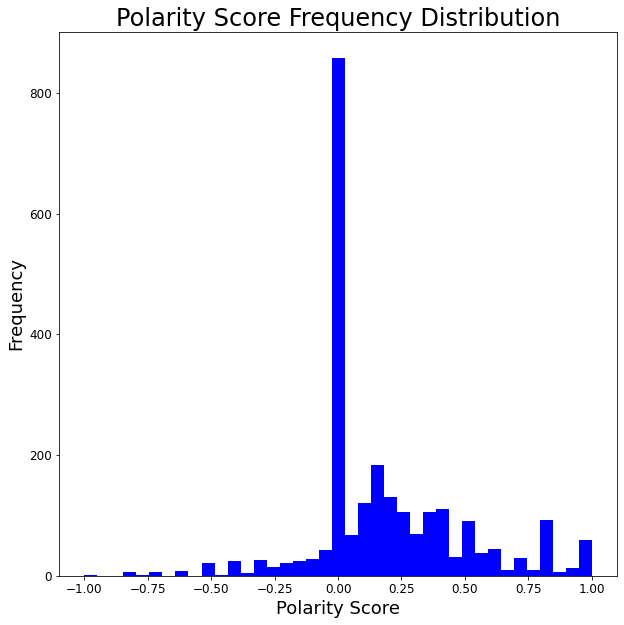

In [41]:
x = apl_prd['polarity']

plt.figure(figsize=(10,10))
plt.hist(x,bins='auto',color = 'blue')
plt.xlabel('Polarity Score', fontsize=18)
plt.xticks(fontsize=12)
plt.ylabel('Frequency', fontsize=18)
plt.yticks(fontsize=12)
plt.title('Polarity Score Frequency Distribution', fontsize = 24);


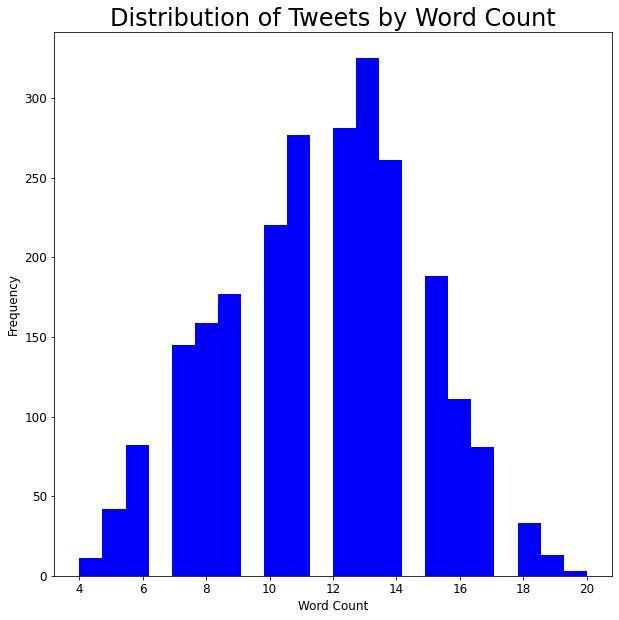

In [44]:
x = apl_prd['word_count']

plt.figure(figsize=(10,10))
plt.hist(x,bins='auto',color = 'blue')
plt.xlabel('Word Count', fontsize = 12)
plt.xticks(fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Distribution of Tweets by Word Count', fontsize = 24);

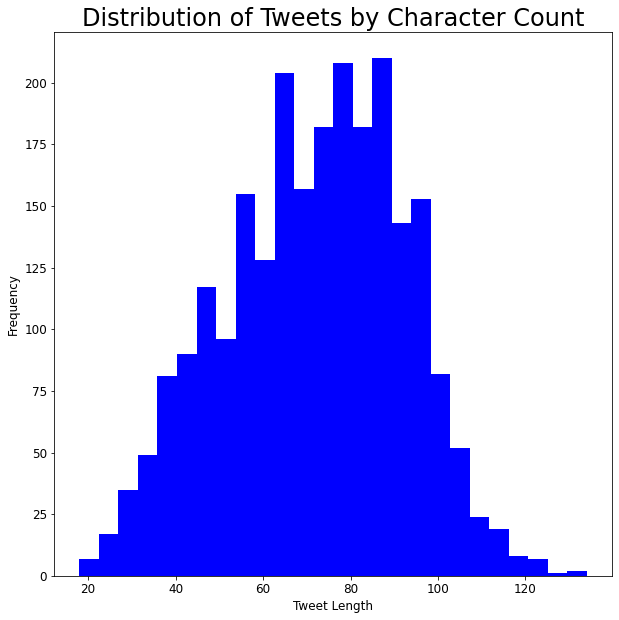

In [45]:
x = apl_prd['review_len']

plt.figure(figsize=(10,10))
plt.hist(x,bins='auto',color = 'blue')
plt.xticks(fontsize=12)
plt.xlabel('Tweet Length', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.yticks(fontsize = 12 )
plt.title('Distribution of Tweets by Character Count', fontsize = 24);

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(apl_prd['tweet_text'], 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['tweet_text' , 'count'])

sxsw 2566
mention 1673
ipad 1156
apple 1006
link 922
rt 698
iphone 644
store 571
quot 369
app 351
austin 276
get 246
new 230
pop 225
go 177
open 174
up 164
line 157
one 150
amp 127


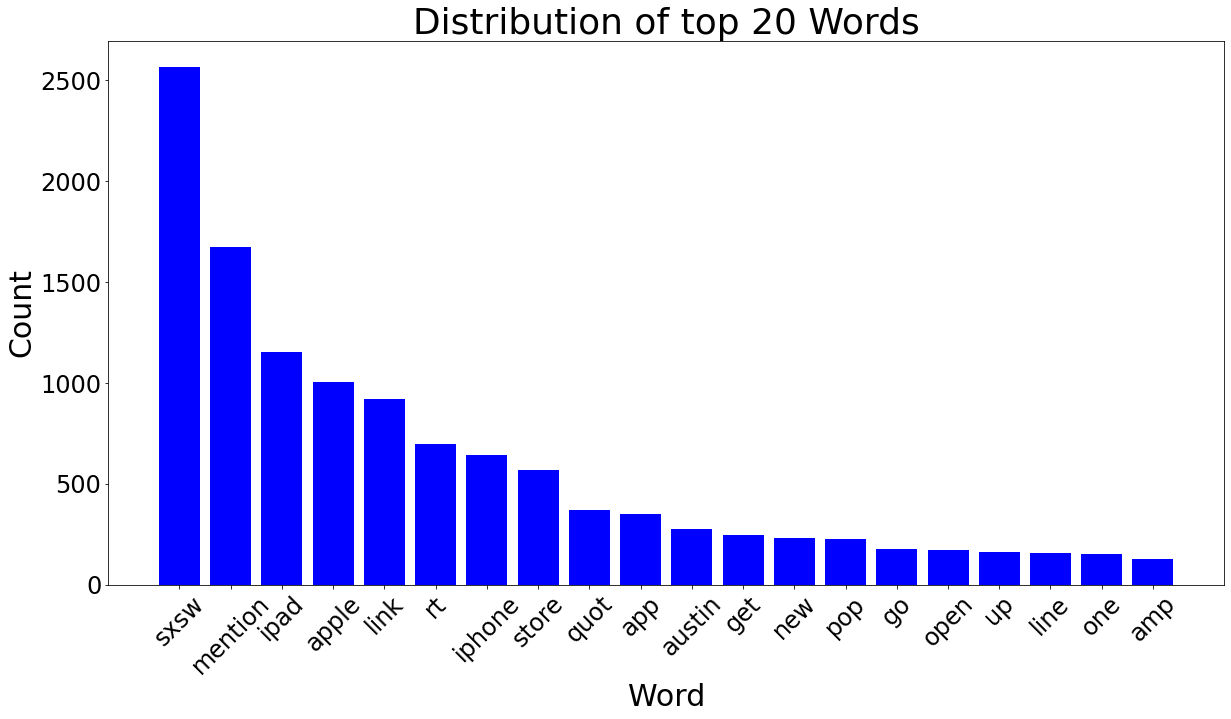

In [47]:
x = df1['tweet_text']
y = df1['count']

plt.figure(figsize=(20,10))
plt.bar(x,y,color = 'blue')
plt.xlabel('Word', fontsize = 30)
plt.xticks(rotation=45, fontsize=24)
plt.ylabel('Count', fontsize = 30)
plt.yticks(fontsize=24)
plt.title('Distribution of top 20 Words', fontsize=36);

In [28]:
df1.head()

,tweet_text,count
0,sxsw,2566
1,mention,1673
2,ipad,1156
3,apple,1006
4,link,922


In [37]:
custom_sw = stopwords.words('english')
custom_sw.extend(["sxsw","mention","ipad","apple","rt","austin","link","iphone","store","quot","app","pop","get","new"] )
custom_sw[-10:]

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words=custom_sw).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(apl_prd['tweet_text'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['tweet_text' , 'count'])
df2.to_csv('apl_prd_custom_stop.csv')

go 177
open 174
line 157
one 150
amp 127
come 121
win 119
like 117
via 106
launch 97
cool 97
day 95
time 91
temporary 88
use 88
apps 87
love 86
downtown 84
free 82
great 82
